# Basic Record Linkage with Parallel Processing

When dealing with data from different sources, whether its from surveys, internal data, external data vendors, or scraped from the web, we often want to link people or companies across the datasets. Unfortunately, we almost never start with perfectly clean data. Even when data is structured, people make absent minded mistakes like mixing up letters in names, individual values are recorded incorrectly, measurement error affects the results, and countless other things can happen. Sometimes, perhaps even more frustratingly, different sources use different names for the same entity (Last.FM vs. LastFM, J.P. Morgan Chase vs. JP Morgan Chase NA).

These little discrepancies make it impossible to simply merge the data together on the unique identifiers.
Trying to link individual or company data across sources is called record linkage, and it can be extremely time consuming.

Fortunately, we can make this task significantly faster by parallelizing the code. In this post, I'll walk through basic record linkage (based on string similarity) with and without parallel processing, and show how the speed differences change with the size of the data.

# Getting Some Data

First things first. I need a toy dataset to play with. I'll download a list of company names from the SEC, as these are what are commonly misspelled in datasets.

In [104]:
import pandas as pd
import requests
import bs4
import multiprocessing as mp
import numpy as np
import time
from difflib import SequenceMatcher

In [2]:
sec_list_html = requests.get('https://www.sec.gov/rules/other/4-460list.htm').content
sec_list_soup = bs4.BeautifulSoup(sec_list_html, 'lxml')
companies_list = sec_list_soup.find_all('tr')[1:-1]
companies_list_clean = [str(x.text.strip()).lower() for x in companies_list]

Let's take a quick look.

In [66]:
companies_list_clean[:5]

['3com corp',
 '3m company',
 'a.g. edwards inc.',
 'abbott laboratories',
 'abercrombie & fitch co.']

Looks good.

I should probably be happy about this, but I somehow couldn't find a list of company names with spelling errors. So I'll need to create a synthetic dataset with mistakes by randomly switching a few of the letters in the company names around.

# Creating Synthetic Data
I'll define a function `switch_3_characters_randomly` to make my synthetic list of company names.

In [70]:
def switch_3_characters_randomly(name, seed = None):
    if seed:
        np.random.seed(seed)
    name_split = list(name)
    flip_indices = np.random.choice(len(name), 3, replace = False)
    a, b, c = flip_indices[0], flip_indices[1], flip_indices[2]
    name_split[a], name_split[b], name_split[c] = name_split[c], name_split[b], name_split[a]
    return ''.join(name_split)

Time to try it out

In [73]:
synthetic_companies_list = map(switch_3_characters_randomly, companies_list_clean)
print synthetic_companies_list[:5]
print companies_list_clean[:5]

['mco3 corp', '3m copmany', 'a.g. edwards inc.', 'abbottrlabo atories', 'abercro bie & fitchmco.']
['3com corp', '3m company', 'a.g. edwards inc.', 'abbott laboratories', 'abercrombie & fitch co.']


Perfect! Looks like it would be a nightmare to try and merge two datasets on these company names. Time to do

# Fuzzy Matching

There are many very smart algorithms for record linkage (William Cohen at Carnegie Mellon has some great information about smart algorithms on his [website](http://www.cs.cmu.edu/~wcohen/)).

But, since I'm using a toy example, I'll implement a basic record linkage algorithm that I'd argue is still the most commonly used. This algorithm will calculate the number of matching sequences in two strings and the corresponding similarity ratio. For information about this, check out the `difflib` [documentation](https://docs.python.org/2/library/difflib.html)

First, I'll define a function to get the similarity ratio of two company names.

In [78]:
def match_ratio(name1, name2):
    s = SequenceMatcher(None, name1, name2)
    return s.ratio()

In [79]:
match_ratio(switch_3_characters_randomly('Abercrombie & Fitch Co.'),
            switch_3_characters_randomly('Abercrombie & Fitch Co.'))

0.8260869565217391

Next, I'll define a function to "fuzzy match" (matching based on the similarity ratio) an individual synthetic company names with the real company names. I'll decide that a similarity ratio > 0.75 constitutes a match. By using a `flag` variable, we can make sure our output `match_list` has a value for every company checked (even if no match is found). This may or may not be desirable depending on the goal.

In [80]:
def get_basic_fuzzy_matches(synthetic_name, threshold = 0.75):
    match_list = []
    flag = None
    for name1 in companies_list_clean:
        ratio = match_ratio(name1, synthetic_name)
        if ratio > threshold:
            if not flag:
                flag = 1
            match_list.append((synthetic_name, name1, ratio))
            
    if not flag:
        match_list.append((synthetic_name, None, 0))
            
    return match_list

In [83]:
get_basic_fuzzy_matches(synthetic_companies_list[12])

[('idmanistaff, inc.', 'administaff, inc.', 0.8823529411764706)]

Let's do a quick test run to see if the functions are working. I'll map our function to some of the synthetic company names and see how we did.

In [93]:
matches = map(get_basic_fuzzy_matches, synthetic_companies_list[:50])
matches[:5]

[[('mco3 corp', '3com corp', 0.7777777777777778),
  ('mco3 corp', 'fmc corp', 0.8235294117647058)],
 [('3m copmany', '3m company', 0.9)],
 [('a.g. edwards inc.', 'a.g. edwards inc.', 1.0)],
 [('abbottrlabo atories', 'abbott laboratories', 0.8947368421052632)],
 [('abercro bie & fitchmco.', 'abercrombie & fitch co.', 0.9130434782608695)]]

Not bad! We clearly matched some correctly, but also have some false matches. Fuzzy matching is really useful, but it still requires going through the matched pairs to make sure the potential matches are correct. This takes some time, but _**way**_ less time than matching by hand.

# Parallel Fuzzy Matching

Okay, so we've got the function working. How do we parallelize it? By shamelessly using the simple method detailed in [blog post](http://chriskiehl.com/article/parallelism-in-one-line/) by Chris Kiehl. In Python, we can map functions to data in parallel by using the `multiprocessing` module. Instead of using Python's base `map` function like I did above, I'll use the `map` function from `multiprocessing`.

To actually implement the parallel fuzzy match I will:
1. Initialize a multiprocessing.Pool object as `pool`
2. Use the `map` function from `pool` and pass it my fuzzy match function and the synthetic companies list
3. Close the pool
4. Join the output from the pool workers

It's really that simple.

In [90]:
pool = mp.Pool()
pooled_matches = pool.map(get_basic_fuzzy_matches, synthetic_companies_list[:50])
pool.close()
pool.join()

This should be the same as bedore. I'll make sure they're the same and look at the first few matches

In [95]:
print pooled_matches == matches
pooled_matches[:5]

True


[[('mco3 corp', '3com corp', 0.7777777777777778),
  ('mco3 corp', 'fmc corp', 0.8235294117647058)],
 [('3m copmany', '3m company', 0.9)],
 [('a.g. edwards inc.', 'a.g. edwards inc.', 1.0)],
 [('abbottrlabo atories', 'abbott laboratories', 0.8947368421052632)],
 [('abercro bie & fitchmco.', 'abercrombie & fitch co.', 0.9130434782608695)]]

Looks like everything works correctly. But why go through this effort? How much faster is it actually?

# Timing the Matching

To see how much better the parallel version is, I'll time how long the fuzzy matching takes for different sized datasets in the standard form and in the parallel form.

In [98]:
indices = map(int, np.linspace(0, len(companies_list_clean), 10))
indices

[0, 105, 210, 315, 420, 526, 631, 736, 841, 947]

### Standard Fuzzy Matching

In [31]:
times_list = []
for i in indices[1:]:
    print i
    t0 = time.time()
    matches = map(get_basic_fuzzy_matches, synthetic_companies_list[:i+1])
    t1 = time.time()
    times_list.append(t1-t0)

105
210
315
420
526
631
736
841
947


### Parallel Fuzzy Matching

In [34]:
times_list_pool = []
for i in indices[1:]:
    print i
    pool = mp.Pool()
    t0 = time.time()
    pooled_matches = pool.map(get_basic_fuzzy_matches, synthetic_companies_list[:i+1])
    t1 = time.time()
    pool.close()
    pool.join()
    times_list_pool.append(t1-t0)

105
210
315
420
526
631
736
841
947


### Plotting the Time at Different Sizes

In [105]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

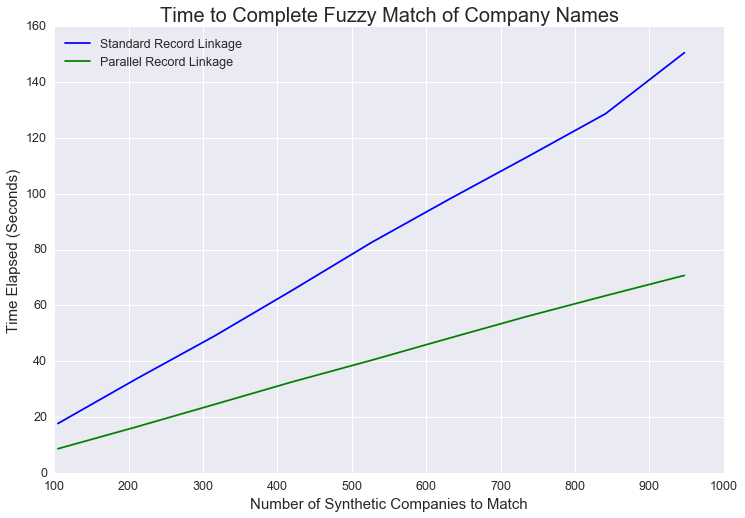

In [113]:
f = plt.figure(figsize = (12, 8))
ax = plt.axes()
sns.set(font_scale = 1.25)
plt.plot(indices[1:], times_list, color = 'blue', label = 'Standard Record Linkage')
plt.plot(indices[1:], times_list_pool, color = 'green', label = 'Parallel Record Linkage')
plt.xlabel('Number of Synthetic Companies to Match', size = 15)
plt.ylabel('Time Elapsed (Seconds)', size = 15)
ax.xaxis.set_label_position('bottom')
sns.despine(left = True, bottom = True)
plt.title('Time to Complete Fuzzy Match of Company Names', size = 20)
plt.legend(loc = 'best')

As the size of the dataset increases, the time value of parallel processing increases. With small datasets, parallel processing isn't much faster. As the dataset gets larger, parallel processing is significantly faster. This makes sense. In order to execute the code in parallel, more actions have to be taken under the hood. The computer needs to divide the data, store metadata about the divisions, and recombine the data at the end. This is all in addition to mapping the function to the data. This takes non-zero time, so the benefit of parallel programming increases in the size of the dataset (the slope of the green line in the graph is shallower).

# Conclusion

In this example, we didn't have that many entities to compare. Our real company dataset has only 947 companies. Parallel record linkage was 2-3 times faster, but we could handle this task without it since it still doesn't take that long. With more cores to utilize (my laptop only has a couple of cores), the parallel fuzzy match would be even faster and scale more effectively to massive datasets. This kind of standard record linkage lends itself nicely to being distributed on a computer cluster. In fact, that's how I would usually run this kind of code.

In [43]:
import pandas as pd

data = pd.DataFrame({'indices':indices[1:],
                   'times_list_sequential':times_list,
                   'pool_6_parallel':times_list_pool})

In [44]:
data.to_csv('fuzzy_matching_time_comparison.csv', index = False)